[kaggle url](https://www.kaggle.com/competitions/linking-writing-processes-to-writing-quality/) 

In [1]:
import warnings
import re
from collections import Counter, defaultdict
import pandas as pd

pd.set_option("display.max_columns", None)
import numpy as np
from tqdm.autonotebook import tqdm
import torch


if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# preprocessing
from scipy.stats import stats, skew, kurtosis
from sklearn.model_selection import train_test_split, KFold, GroupKFold, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
import optuna

# model
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

warnings.simplefilter("ignore")

C:\Users\zzc\AppData\Local\Temp\ipykernel_36064\2446390483.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
train = pd.read_csv("./dataset/train_logs.csv")
train_score = pd.read_csv("./dataset/train_scores.csv")
test = pd.read_csv("./dataset/test_logs.csv")

In [3]:
train.head(10)

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1
5,001519c8,6,107296,107400,104,Input,q,q,q,3,1
6,001519c8,7,107469,107596,127,Input,q,q,q,4,1
7,001519c8,8,107659,107766,107,Input,q,q,q,5,1
8,001519c8,9,107743,107852,109,Input,q,q,q,6,1
9,001519c8,10,107840,107978,138,Input,Space,Space,,7,1


In [4]:
train["down_event"].unique()

array(['Leftclick', 'Shift', 'q', 'Space', 'Backspace', '.', ',', 'Enter',
       'ArrowLeft', "'", ';', 'ArrowRight', '-', '?', 'Tab', '"',
       'ArrowUp', 'ArrowDown', 'Rightclick', '=', 'CapsLock', 'Control',
       'c', 'v', '/', 'Delete', ':', 'z', '[', '$', '(', ')', '+', 'Home',
       'End', '\\', 'Meta', '*', '&', 'AudioVolumeMute', 'x', '!',
       'Insert', 'MediaPlayPause', 'NumLock', '%', 'V', '>', 'Alt',
       'AudioVolumeUp', 'ContextMenu', 'AudioVolumeDown', 'a', '<',
       'PageDown', ']', 'Middleclick', '@', 'F12', 'j', '\x96', 'Dead',
       't', 's', 'n', 'y', '{', 'ScrollLock', '¿', 'Process', '}',
       'MediaTrackPrevious', 'MediaTrackNext', 'F3', '^', 'Unidentified',
       'Cancel', '2', 'i', 'd', 'r', 'e', '`', '\x9b', 'm', '#', '~',
       'PageUp', 'T', 'A', 'b', 'S', 'ModeChange', '_', 'Escape', 'F11',
       'Unknownclick', 'AltGraph', 'F10', 'h', 'F15', 'Clear', 'OS', 'F',
       'C', 'o', 'Ä±', 'f', 'u', 'w', 'p', 'g', 'M', 'l', '|',
       'â\x80\x

In [5]:
train[~train["text_change"].str.contains("q")]["text_change"].unique()

array(['NoChange', ' ', '.', ',', '\n', "'", ';', '-', '?', '"', '\n ',
       '=', '/', ':', '[', '$', '(', ')', '+', '\\', '*', '&', '!', '%',
       '>', ', ', ', => .', ', => ;', '. ', '\n\n\n\n\n\n\n\n\n\n\n\n',
       '\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n', '\n\n\n\n', '<', '.... => .',
       ']', '\n => .', '@', '\x96', '".', '"\n', '  => -', ', =>  ',
       '            ', '{', '  => ,', '- ', '. => ,', '\x94', '\x93', '¿',
       '}', '. =>  ', '  => \n', '^', '`', '\x9b', ',  => .', '...', '#',
       '~', '\n\n', '_', '.  =>  ', ',  =>  ', '? ', ' - => ,', '!  =>  ',
       'Ä±', '. => ?', '\n =>  ', '|', 'â\x80\x93', '\x97',
       '                                                                         ',
       '                                                                                                                                                                                                                                                                         

In [6]:
train[~train["activity"].str.startswith("Move")]["activity"].unique()

array(['Nonproduction', 'Input', 'Remove/Cut', 'Replace', 'Paste'],
      dtype=object)

In [7]:
participant_id = "0042269b"
target_col = "activity"

participant_logs = train[train["id"] == participant_id]

participant_logs.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
5011,0042269b,1,4441,4540,99,Nonproduction,Leftclick,Leftclick,NoChange,0,0
5012,0042269b,2,21276,21276,0,Nonproduction,Shift,Shift,NoChange,0,0
5013,0042269b,3,21335,21430,95,Input,q,q,q,1,1
5014,0042269b,4,21533,21665,132,Input,q,q,q,2,1
5015,0042269b,5,21594,21742,148,Input,q,q,q,3,1


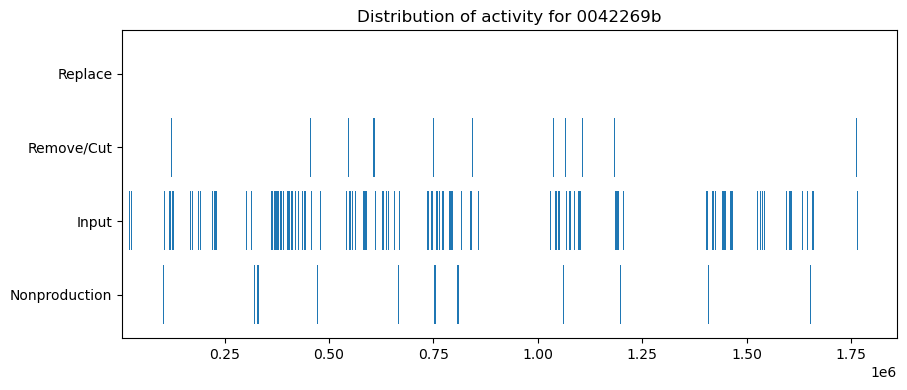

In [8]:

fig, ax = plt.subplots(1, figsize=(10, 4))

ax.barh(
    y=participant_logs[target_col],
    width=participant_logs["action_time"],
    left=participant_logs["down_time"],
)
plt.title(f"Distribution of {target_col} for {participant_id}")
plt.show()

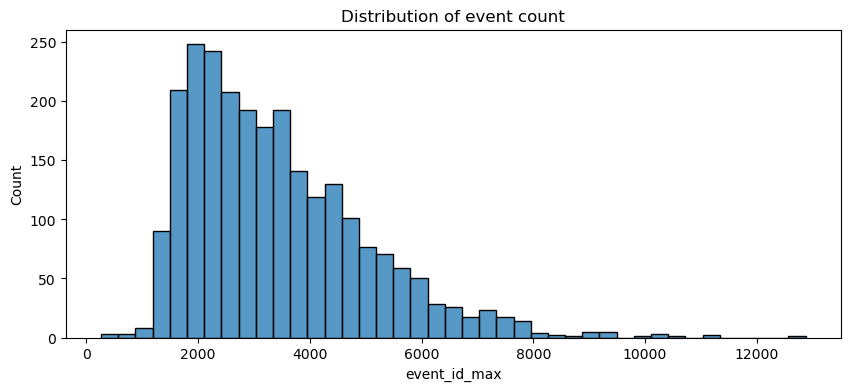

In [9]:
event_cnt_df = (
    train.groupby("id")
    .agg({"event_id": "max"})
    .rename(columns={"event_id": "event_id_max"})
    .sort_values("event_id_max", ascending=False)
)

# event_cnt_df.head()
fig, ax = plt.subplots(1, figsize=(10, 4))

sns.histplot(event_cnt_df["event_id_max"], ax=ax)
plt.title("Distribution of event count")
plt.show()

In [10]:
event_cnt_df.describe()

,event_id_max
count,2471.000000
mean,3401.820316
std,1578.850387
min,262.000000
25%,2193.500000
50%,3082.000000
75%,4301.000000
max,12876.000000


In [11]:
class CFG:
    seed = 44
    response_variate = "score"
    # optuna
    use_optuna_tuning = True
    test_size_optuna = 0.2
    num_estimators = 5000
    num_trials_optuna = 80
    num_trials_early_stopping = 40

    # fold
    num_fold = 10

    

In [12]:
class Preprocessor:
    def __init__(self) -> None:
        # self.seed = seed

        self.activities = ["Nonproduction", "Input", "Remove/Cut", "Replace", "Paste"]
        self.events = ['Leftclick', 'Shift', 'q', 'Space', 'Backspace', '.', ',', 'Enter',
       'ArrowLeft', "'", ';', 'ArrowRight', '-', '?', 'Tab', '"',
       'ArrowUp', 'ArrowDown', 'Rightclick', 'Unidentified', 'Delete', "Other"]
        self.punctuations = ['"', '.', ',', "'", '-', ';', ':', '?', '!', '<', '>', '/',
                        '@', '#', '$', '%', '^', '&', '*', '(', ')', '_', '+']
        self.text_changes = ["q", 'NoChange', ' ', '.', ',', '\n', "'", ';', '-', '?', '"',
       '=', '/', ':', '+']
        self.gaps = [1, 2, 3, 5, 10, 20, 50]

    def count(self, df: pd.DataFrame, colname: str, collections: list) -> pd.DataFrame:
        tmp_df = df.groupby("id").agg({colname: list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df[colname].values):
            items = list(Counter(li).items())
            di = defaultdict(int)
            if "Other" not in collections:
                collections.append("Other")
            for act in collections:
                di[act] = 0
            for act, cnt in items:
                if act in collections:
                    di[act] = cnt
                else:
                    di["Other"] += cnt
            ret.append(di)
            
        ret = pd.DataFrame(ret)
        cols = [f"{colname}_{i}_count" for i in range(len(ret.columns))]
        ret.columns = cols
        return ret
    
    def activity_count(self, df: pd.DataFrame) -> pd.DataFrame:
        return self.count(df, "activity", self.activities)
    
    def event_count(self, df: pd.DataFrame, colname: str) -> pd.DataFrame:
        return self.count(df, colname, self.events)
    
    def match_puncatuation(self, df: pd.DataFrame) -> pd.DataFrame:
        tmp_df = df.groupby("id").agg({"text_change": list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df["text_change"].values):
            cnt = 0
            items = list(Counter(li).items())
            for k, v in items:
                if k in self.punctuations:
                    cnt += v
            ret.append(cnt)
        return pd.DataFrame({"punct_cnt": ret})

    def get_input_words(self, df: pd.DataFrame) -> pd.DataFrame:
        tmp_df = df[(~df["text_change"].str.contains("=>"))&(df["text_change"] != "NoChange")].reset_index(drop=True)
        tmp_df = df.groupby("id").agg({"text_change": list}).reset_index()
        tmp_df["text_change"] = tmp_df["text_change"].apply(lambda x: "".join(x))
        tmp_df["text_change"] = tmp_df["text_change"].apply(lambda x: re.findall(r"q+", x))
        tmp_df["input_word_count"] = tmp_df["text_change"].apply(len)
        tmp_df["input_word_count_mean"] = tmp_df['text_change'].apply(lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0))
        tmp_df["input_word_count_max"] = tmp_df['text_change'].apply(lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0))
        tmp_df["input_word_count_std"] = tmp_df['text_change'].apply(lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0))
        tmp_df.drop("text_change", axis=1, inplace=True)
        return tmp_df
        

    def make_feats(self, df: pd.DataFrame):
        feats = pd.DataFrame({"id": df["id"].unique().tolist()})
        
        # shift feats
        for gap in self.gaps:
            df[f"up_time_shift{gap}"] = df.groupby("id")["up_time"].shift(gap)
            df[f"action_time_gap{gap}"] = df["down_time"] - df[f"up_time_shift{gap}"]
        df.drop(columns=[f"up_time_shift{gap}" for gap in self.gaps], inplace=True)
        
        for gap in self.gaps:
            df[f"cursor_position_shift{gap}"] = df.groupby("id")["cursor_position"].shift(gap)
            df[f"cursor_position_change{gap}"] = df[f"cursor_position_shift{gap}"] - df["cursor_position"]
            df[f"cursor_position_abs_change{gap}"] = np.abs(df[f"cursor_position_change{gap}"])
        df.drop(columns=[f"cursor_position_shift{gap}" for gap in self.gaps], inplace=True)
        
        for gap in self.gaps:
            df[f"word_count_shift{gap}"] = df.groupby("id")["word_count"].shift(gap)
            df[f"word_count_change{gap}"] = df["word_count"] - df[f"word_count_shift{gap}"]
            df[f"word_count_abs_change{gap}"] = np.abs(df[f"word_count_change{gap}"])
        df.drop(columns=[f"word_count_shift{gap}" for gap in self.gaps], inplace=True)
        
        # aggregate statistical feats
        feat_stat = [
            ("event_id", ["max"]),
            ("up_time", ["max"]),
            ("action_time", ["max"]),
            ("activity", ["nunique"]),
            ("down_event", ["nunique"]),
            ("up_event", ["nunique"]),
            ("text_change", ["nunique"]),
            ("cursor_position", ["nunique", "mean", "max"]),
            ("word_count", ["nunique", "mean", "max"]),
        ]
        for gap in self.gaps:
            feat_stat.extend([
                (f"action_time_gap{gap}", ["mean", "std", "min", "max", "sum", skew, kurtosis]),
                (f"cursor_position_change{gap}", ["mean", "std", "min", "max", "sum", skew, kurtosis]),
                (f"word_count_change{gap}", ["mean", "std", "min", "max", "sum", skew, kurtosis]),
            ])
        
        pbar = tqdm(feat_stat)
        
        
        for col, methods in pbar:
            for method in methods:
                pbar.set_postfix()
                if isinstance(method, str):
                    method_name = method
                else:
                    method_name = method.__name__
                    
                pbar.set_postfix(column=col, method=method_name)
                tmp_df = df.groupby(["id"]).agg({col: method}).reset_index().rename(columns={col: f"{col}_{method_name}"})
                feats = feats.merge(tmp_df, on="id", how="left")
                
        tmp_df = self.activity_count(df)
        feats = pd.concat([feats, tmp_df], axis=1)
        
        tmp_df = self.event_count(df, "down_event")
        feats = pd.concat([feats, tmp_df], axis=1)
        tmp_df = self.event_count(df, "up_event")
        feats = pd.concat([feats, tmp_df], axis=1)
        
        tmp_df = self.count(df, "text_change", self.text_changes)
        feats = pd.concat([feats, tmp_df], axis=1)
        
        tmp_df = self.match_puncatuation(df)
        feats = pd.concat([feats, tmp_df], axis=1)
        
        tmp_df = self.get_input_words(df)
        feats = pd.merge(feats, tmp_df, on="id", how="left")
        
        # compare feats
        print("Engineering ratios data")
        feats["word_time_ratio"] = feats["word_count_max"] / feats["up_time_max"]
        feats["word_event_ratio"] = feats["word_count_max"] / feats["event_id_max"]
        feats["event_time_ratio"] = feats["event_id_max"] / feats["up_time_max"]
        feats["idle_time_ratio"] = feats["action_time_max"] / feats["up_time_max"]
        
        
        print("Done!")
        return feats
            

In [13]:
preprocessor = Preprocessor()

print("start making train feats")
train_feats = preprocessor.make_feats(train)

print("start making test feats")
test_feats = preprocessor.make_feats(test)

start making train feats


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/2471 [00:00<?, ?it/s]

  0%|          | 0/2471 [00:00<?, ?it/s]

  0%|          | 0/2471 [00:00<?, ?it/s]

  0%|          | 0/2471 [00:00<?, ?it/s]

  0%|          | 0/2471 [00:00<?, ?it/s]

Engineering ratios data
Done!
start making test feats


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Engineering ratios data
Done!


In [14]:
train_feats = train_feats.merge(train_score, on='id', how='left')

In [15]:
train_feats.head()

,id,event_id_max,up_time_max,action_time_max,activity_nunique,down_event_nunique,up_event_nunique,text_change_nunique,cursor_position_nunique,cursor_position_mean,cursor_position_max,word_count_nunique,word_count_mean,word_count_max,action_time_gap1_mean,action_time_gap1_std,action_time_gap1_min,action_time_gap1_max,action_time_gap1_sum,action_time_gap1_skew,action_time_gap1_kurtosis,cursor_position_change1_mean,cursor_position_change1_std,cursor_position_change1_min,cursor_position_change1_max,cursor_position_change1_sum,cursor_position_change1_skew,cursor_position_change1_kurtosis,word_count_change1_mean,word_count_change1_std,word_count_change1_min,word_count_change1_max,word_count_change1_sum,word_count_change1_skew,word_count_change1_kurtosis,action_time_gap2_mean,action_time_gap2_std,action_time_gap2_min,action_time_gap2_max,action_time_gap2_sum,action_time_gap2_skew,action_time_gap2_kurtosis,cursor_position_change2_mean,cursor_position_change2_std,cursor_position_change2_min,cursor_position_change2_max,cursor_position_change2_sum,cursor_position_change2_skew,cursor_position_change2_kurtosis,word_count_change2_mean,word_count_change2_std,word_count_change2_min,word_count_change2_max,word_count_change2_sum,word_count_change2_skew,word_count_change2_kurtosis,action_time_gap3_mean,action_time_gap3_std,action_time_gap3_min,action_time_gap3_max,action_time_gap3_sum,action_time_gap3_skew,action_time_gap3_kurtosis,cursor_position_change3_mean,cursor_position_change3_std,cursor_position_change3_min,cursor_position_change3_max,cursor_position_change3_sum,cursor_position_change3_skew,cursor_position_change3_kurtosis,word_count_change3_mean,word_count_change3_std,word_count_change3_min,word_count_change3_max,word_count_change3_sum,word_count_change3_skew,word_count_change3_kurtosis,action_time_gap5_mean,action_time_gap5_std,action_time_gap5_min,action_time_gap5_max,action_time_gap5_sum,action_time_gap5_skew,action_time_gap5_kurtosis,cursor_position_change5_mean,cursor_position_change5_std,cursor_position_change5_min,cursor_position_change5_max,cursor_position_change5_sum,cursor_position_change5_skew,cursor_position_change5_kurtosis,word_count_change5_mean,word_count_change5_std,word_count_change5_min,word_count_change5_max,word_count_change5_sum,word_count_change5_skew,word_count_change5_kurtosis,action_time_gap10_mean,action_time_gap10_std,action_time_gap10_min,action_time_gap10_max,action_time_gap10_sum,action_time_gap10_skew,action_time_gap10_kurtosis,cursor_position_change10_mean,cursor_position_change10_std,cursor_position_change10_min,cursor_position_change10_max,cursor_position_change10_sum,cursor_position_change10_skew,cursor_position_change10_kurtosis,word_count_change10_mean,word_count_change10_std,word_count_change10_min,word_count_change10_max,word_count_change10_sum,word_count_change10_skew,word_count_change10_kurtosis,action_time_gap20_mean,action_time_gap20_std,action_time_gap20_min,action_time_gap20_max,action_time_gap20_sum,action_time_gap20_skew,action_time_gap20_kurtosis,cursor_position_change20_mean,cursor_position_change20_std,cursor_position_change20_min,cursor_position_change20_max,cursor_position_change20_sum,cursor_position_change20_skew,cursor_position_change20_kurtosis,word_count_change20_mean,word_count_change20_std,word_count_change20_min,word_count_change20_max,word_count_change20_sum,word_count_change20_skew,word_count_change20_kurtosis,action_time_gap50_mean,action_time_gap50_std,action_time_gap50_min,action_time_gap50_max,action_time_gap50_sum,action_time_gap50_skew,action_time_gap50_kurtosis,cursor_position_change50_mean,cursor_position_change50_std,cursor_position_change50_min,cursor_position_change50_max,cursor_position_change50_sum,cursor_position_change50_skew,cursor_position_change50_kurtosis,word_count_change50_mean,word_count_change50_std,word_count_change50_min,word_count_change50_max,word_count_change50_sum,word_count_change50_skew,word_count_change50_kurtosis,activity_0_count,activity_1_c

In [16]:
test_feats.columns.to_list()

['id',
 'event_id_max',
 'up_time_max',
 'action_time_max',
 'activity_nunique',
 'down_event_nunique',
 'up_event_nunique',
 'text_change_nunique',
 'cursor_position_nunique',
 'cursor_position_mean',
 'cursor_position_max',
 'word_count_nunique',
 'word_count_mean',
 'word_count_max',
 'action_time_gap1_mean',
 'action_time_gap1_std',
 'action_time_gap1_min',
 'action_time_gap1_max',
 'action_time_gap1_sum',
 'action_time_gap1_skew',
 'action_time_gap1_kurtosis',
 'cursor_position_change1_mean',
 'cursor_position_change1_std',
 'cursor_position_change1_min',
 'cursor_position_change1_max',
 'cursor_position_change1_sum',
 'cursor_position_change1_skew',
 'cursor_position_change1_kurtosis',
 'word_count_change1_mean',
 'word_count_change1_std',
 'word_count_change1_min',
 'word_count_change1_max',
 'word_count_change1_sum',
 'word_count_change1_skew',
 'word_count_change1_kurtosis',
 'action_time_gap2_mean',
 'action_time_gap2_std',
 'action_time_gap2_min',
 'action_time_gap2_max',
 '

In [17]:
train_feats.columns.to_list()

['id',
 'event_id_max',
 'up_time_max',
 'action_time_max',
 'activity_nunique',
 'down_event_nunique',
 'up_event_nunique',
 'text_change_nunique',
 'cursor_position_nunique',
 'cursor_position_mean',
 'cursor_position_max',
 'word_count_nunique',
 'word_count_mean',
 'word_count_max',
 'action_time_gap1_mean',
 'action_time_gap1_std',
 'action_time_gap1_min',
 'action_time_gap1_max',
 'action_time_gap1_sum',
 'action_time_gap1_skew',
 'action_time_gap1_kurtosis',
 'cursor_position_change1_mean',
 'cursor_position_change1_std',
 'cursor_position_change1_min',
 'cursor_position_change1_max',
 'cursor_position_change1_sum',
 'cursor_position_change1_skew',
 'cursor_position_change1_kurtosis',
 'word_count_change1_mean',
 'word_count_change1_std',
 'word_count_change1_min',
 'word_count_change1_max',
 'word_count_change1_sum',
 'word_count_change1_skew',
 'word_count_change1_kurtosis',
 'action_time_gap2_mean',
 'action_time_gap2_std',
 'action_time_gap2_min',
 'action_time_gap2_max',
 '

In [18]:
kfold = KFold(n_splits=CFG.num_fold, shuffle=True, random_state=CFG.seed)

for fold, (_, val_idx) in enumerate(kfold.split(train_feats)):
    train_feats.loc[val_idx, "fold"] = fold

In [19]:
X = train_feats.drop(["id", "fold", CFG.response_variate], axis=1)
Y = train_feats[CFG.response_variate]

In [20]:
def objective(trial: optuna.Trial, data=X, target=Y, model_="xgb"):
    if model_ == "xgb":
        model = XGBRegressor(
            random_state=CFG.seed,
            n_estimators=CFG.num_estimators,
            # n_estimators=trial.suggest_int("n_estimators", 32, 1024),
            eta=trial.suggest_float("eta", 0.001, 0.3),
            max_depth=trial.suggest_int("max_depth", 1, 10),
            reg_lambda=trial.suggest_float("reg_lambda", 0.01, 10),
            subsample=trial.suggest_float("subsample", 0.01, 1),
            min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
            colsample_bytree=trial.suggest_float("colsample_bytree", 0.01, 1),
            objective=trial.suggest_categorical("objective", ["reg:squarederror"]),
        )
    elif model_ == "lgbm":
        model = LGBMRegressor(
            random_state=CFG.seed,
            n_estimators=CFG.num_estimators,
            # n_estimators=trial.suggest_int("n_estimators", 32, 1024),
            learning_rate=trial.suggest_float("learning_rate", 0.001, 0.5, log=True),
            max_depth=trial.suggest_int("max_depth", 1, 10),
            num_leaves=trial.suggest_int("num_leaves", 2, 1024),
            reg_lambda=trial.suggest_float("reg_lambda", 0.001, 10),
            reg_alpha=trial.suggest_float("reg_alpha", 0, 10),
            subsample=trial.suggest_float("subsample", 0.001, 1),
            colsample_bytree=trial.suggest_float("colsample_bytree", 0.5, 1),
            min_child_samples=trial.suggest_int("min_child_samples", 2, 1024),
            min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
            # objective=trial.suggest_categorical("objective", ["multiclass"]),
            metric=trial.suggest_categorical("metric", ["regression"]),
            boosting_type=trial.suggest_categorical("boosting_type", ["gbdt"]),
        )
    elif model_ == "catboost":
        model = CatBoostRegressor(
            iterations=trial.suggest_int("iterations", 32, 1024),
            learning_rate=trial.suggest_float("learning_rate", 0.001, 0.3),
            depth=trial.suggest_int("depth", 1, 10),
            l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 0.01, 10),
            grow_policy=trial.suggest_categorical("grow_policy", ["Depthwise"]),
            bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
            od_type=trial.suggest_categorical("od_type", ["Iter"]),
            # eval_metric=trial.suggest_categorical("eval_metric", ["TotalF1"]),
            eval_metric=trial.suggest_categorical("eval_metric", ["RMSE"]),
            loss_function=trial.suggest_categorical("loss_function", ["RMSE"]),
            random_state=CFG.seed,
            verbose=trial.suggest_categorical("verbose", [0]),
        )

    train_x, valid_x, train_y, valid_y = train_test_split(
        data, target, test_size=CFG.test_size_optuna, random_state=CFG.seed
    )
    model.fit(
        train_x,
        train_y,
        eval_set=[(valid_x, valid_y)],
        early_stopping_rounds=CFG.num_trials_early_stopping,
        verbose=False,
    )

    preds = model.predict(valid_x)

    rmse = mean_squared_error(valid_y, preds, squared=False)

    return rmse

In [21]:
from functools import partial
import json

best_hyperparams_map = {}
# for mod in ["xgb", "lgbm", "catboost"]:
for mod in ["lgbm"]:
    objective_func = partial(objective, model_=mod)

    study: optuna.Study = optuna.create_study(
        direction="minimize", study_name="Optimize boosting hyperparameters"
    )
    study.optimize(objective_func, n_trials=CFG.num_trials_optuna)

    best_hyperparams = study.best_params

    best_hyperparams_map[f"best_hyperparams_{mod}"] = best_hyperparams

print(json.dumps(best_hyperparams_map, indent=4))

[I 2023-10-17 09:27:18,665] A new study created in memory with name: Optimize boosting hyperparameters
[I 2023-10-17 09:27:19,226] Trial 0 finished with value: 0.6693156128362743 and parameters: {'eta': 0.16301335001370768, 'max_depth': 4, 'reg_lambda': 1.8986879367979372, 'subsample': 0.48182784095487174, 'min_child_weight': 2, 'colsample_bytree': 0.11959951877602643, 'objective': 'reg:squarederror'}. Best is trial 0 with value: 0.6693156128362743.
[I 2023-10-17 09:27:19,686] Trial 1 finished with value: 0.7442866778670211 and parameters: {'eta': 0.19594812465036068, 'max_depth': 10, 'reg_lambda': 6.710993973178904, 'subsample': 0.01614229494912609, 'min_child_weight': 5, 'colsample_bytree': 0.8743144011516888, 'objective': 'reg:squarederror'}. Best is trial 0 with value: 0.6693156128362743.
[I 2023-10-17 09:27:20,539] Trial 2 finished with value: 0.6678617745535437 and parameters: {'eta': 0.043458997587560166, 'max_depth': 4, 'reg_lambda': 2.0906825115958485, 'subsample': 0.722385724

{
    "best_hyperparams_xgb": {
        "eta": 0.0277178491903082,
        "max_depth": 2,
        "reg_lambda": 2.5019013674200683,
        "subsample": 0.26716117550393814,
        "min_child_weight": 6,
        "colsample_bytree": 0.25490872804893033,
        "objective": "reg:squarederror"
    },
    "best_hyperparams_lgbm": {
        "learning_rate": 0.03358893271147409,
        "max_depth": 3,
        "num_leaves": 886,
        "reg_lambda": 8.915265095382027,
        "reg_alpha": 3.396668585628283,
        "subsample": 0.6320779507949922,
        "colsample_bytree": 0.6062403057954989,
        "min_child_samples": 268,
        "min_child_weight": 9,
        "metric": "regression",
        "boosting_type": "gbdt"
    },
    "best_hyperparams_catboost": {
        "iterations": 685,
        "learning_rate": 0.025794271911017887,
        "depth": 6,
        "l2_leaf_reg": 5.356625887152956,
        "grow_policy": "Depthwise",
        "bootstrap_type": "Bayesian",
        "od_type": 

In [22]:
feature_names = list(filter(lambda x: x not in ["id", "fold", CFG.response_variate], train_feats.columns))

model_dict = defaultdict(dict)

for fold in range(CFG.num_fold):
    X_train = train_feats[train_feats["fold"] != fold][feature_names].reset_index(drop=True)
    Y_train = train_feats[train_feats["fold"] != fold][CFG.response_variate].reset_index(drop=True)
    
    X_val = train_feats[train_feats["fold"] == fold][feature_names].reset_index(drop=True)
    Y_val = train_feats[train_feats["fold"] == fold][CFG.response_variate].reset_index(drop=True)
    
    # for mod in ["xgb", "lgbm", "catboost"]:
    for mod in ["lgbm"]:
        if mod == "xgb":
            model_cls = XGBRegressor
        elif mod == "lgbm":
            model_cls = LGBMRegressor
        elif mod == "catboost":
            model_cls = CatBoostRegressor
        print(f"Training for FOLD {fold} Model {mod}")
        model = model_cls(**best_hyperparams_map[f"best_hyperparams_{mod}"])
        model.fit(
            X_train,
            Y_train,
            eval_names=["train", "valid"],
            eval_set=[(X_train, Y_train), (X_val, Y_val)],
            eval_metric="rmse",
            early_stopping_rounds=CFG.num_trials_early_stopping,
            verbose=False,
        )
        model_dict[mod][fold] = model

Training for FOLD 0 Model lgbm
Training for FOLD 1 Model lgbm
Training for FOLD 2 Model lgbm
Training for FOLD 3 Model lgbm
Training for FOLD 4 Model lgbm
Training for FOLD 5 Model lgbm
Training for FOLD 6 Model lgbm
Training for FOLD 7 Model lgbm
Training for FOLD 8 Model lgbm
Training for FOLD 9 Model lgbm


In [23]:
feature_importances_values = np.asarray([model.feature_importances_ for model in model_dict["lgbm"].values()]).mean(axis=0)

feature_ipmortances_df = pd.DataFrame({"feature": feature_names, "importance": feature_importances_values})

feature_ipmortances_df = feature_ipmortances_df.sort_values("importance", ascending=False).head(50)
feature_ipmortances_df.head()

,feature,importance
172,down_event_6_count,49.3
228,input_word_count_mean,47.5
9,cursor_position_max,35.7
194,up_event_6_count,19.7
178,down_event_12_count,18.5


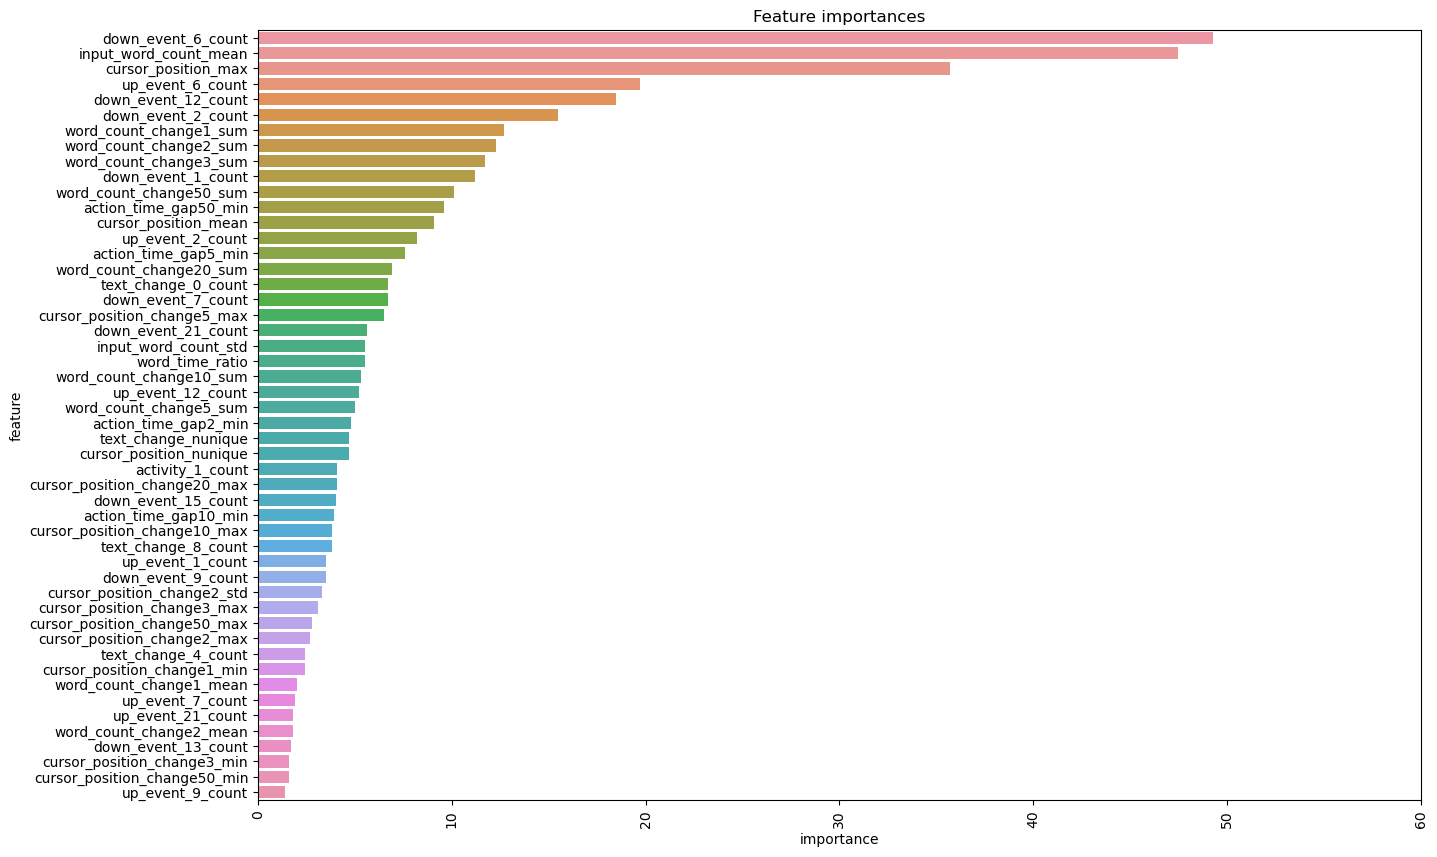

In [24]:
plt.subplots(1, figsize=(15, 10))

ax = sns.barplot(x="importance", y="feature", data=feature_ipmortances_df)
ax.set_title("Feature importances")
# ax.set_label(xlabel="feature", ylabel="importance")
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)
plt.show()

In [25]:
for fold in range(CFG.num_fold):
    X_valid = train_feats[train_feats["fold"] == fold][feature_names]
    Y_valid = train_feats[train_feats["fold"] == fold][CFG.response_variate]

    model = model_dict["lgbm"][fold]

    preds = model.predict(X_valid, num_iteration=model.best_iteration_)

    train_feats.loc[Y_valid.index, f"preds_{CFG.response_variate}"] = preds

rmse = mean_squared_error(
    train_feats[CFG.response_variate],
    np.clip(train_feats[f"preds_{CFG.response_variate}"], a_min=0.5, a_max=6),
    squared=False,
)

print(f"RMSE: {rmse}")

RMSE: 0.6647131154090675


In [27]:
for fold in range(CFG.num_fold):
    X_test = test_feats[feature_names]
    model = model_dict["lgbm"][fold]

    preds = model.predict(X_test, num_iteration=model.best_iteration_)

    test_feats[f"preds_{CFG.response_variate}_fold{fold}"] = preds
    
test_feats[CFG.response_variate] = test_feats[[f"preds_{CFG.response_variate}_fold{i}" for i in range(CFG.num_fold)]].mean(axis=1)
test_feats[CFG.response_variate] = np.clip(test_feats[CFG.response_variate], a_min=0.5, a_max=6)

test_feats.head()

,id,event_id_max,up_time_max,action_time_max,activity_nunique,down_event_nunique,up_event_nunique,text_change_nunique,cursor_position_nunique,cursor_position_mean,cursor_position_max,word_count_nunique,word_count_mean,word_count_max,action_time_gap1_mean,action_time_gap1_std,action_time_gap1_min,action_time_gap1_max,action_time_gap1_sum,action_time_gap1_skew,action_time_gap1_kurtosis,cursor_position_change1_mean,cursor_position_change1_std,cursor_position_change1_min,cursor_position_change1_max,cursor_position_change1_sum,cursor_position_change1_skew,cursor_position_change1_kurtosis,word_count_change1_mean,word_count_change1_std,word_count_change1_min,word_count_change1_max,word_count_change1_sum,word_count_change1_skew,word_count_change1_kurtosis,action_time_gap2_mean,action_time_gap2_std,action_time_gap2_min,action_time_gap2_max,action_time_gap2_sum,action_time_gap2_skew,action_time_gap2_kurtosis,cursor_position_change2_mean,cursor_position_change2_std,cursor_position_change2_min,cursor_position_change2_max,cursor_position_change2_sum,cursor_position_change2_skew,cursor_position_change2_kurtosis,word_count_change2_mean,word_count_change2_std,word_count_change2_min,word_count_change2_max,word_count_change2_sum,word_count_change2_skew,word_count_change2_kurtosis,action_time_gap3_mean,action_time_gap3_std,action_time_gap3_min,action_time_gap3_max,action_time_gap3_sum,action_time_gap3_skew,action_time_gap3_kurtosis,cursor_position_change3_mean,cursor_position_change3_std,cursor_position_change3_min,cursor_position_change3_max,cursor_position_change3_sum,cursor_position_change3_skew,cursor_position_change3_kurtosis,word_count_change3_mean,word_count_change3_std,word_count_change3_min,word_count_change3_max,word_count_change3_sum,word_count_change3_skew,word_count_change3_kurtosis,action_time_gap5_mean,action_time_gap5_std,action_time_gap5_min,action_time_gap5_max,action_time_gap5_sum,action_time_gap5_skew,action_time_gap5_kurtosis,cursor_position_change5_mean,cursor_position_change5_std,cursor_position_change5_min,cursor_position_change5_max,cursor_position_change5_sum,cursor_position_change5_skew,cursor_position_change5_kurtosis,word_count_change5_mean,word_count_change5_std,word_count_change5_min,word_count_change5_max,word_count_change5_sum,word_count_change5_skew,word_count_change5_kurtosis,action_time_gap10_mean,action_time_gap10_std,action_time_gap10_min,action_time_gap10_max,action_time_gap10_sum,action_time_gap10_skew,action_time_gap10_kurtosis,cursor_position_change10_mean,cursor_position_change10_std,cursor_position_change10_min,cursor_position_change10_max,cursor_position_change10_sum,cursor_position_change10_skew,cursor_position_change10_kurtosis,word_count_change10_mean,word_count_change10_std,word_count_change10_min,word_count_change10_max,word_count_change10_sum,word_count_change10_skew,word_count_change10_kurtosis,action_time_gap20_mean,action_time_gap20_std,action_time_gap20_min,action_time_gap20_max,action_time_gap20_sum,action_time_gap20_skew,action_time_gap20_kurtosis,cursor_position_change20_mean,cursor_position_change20_std,cursor_position_change20_min,cursor_position_change20_max,cursor_position_change20_sum,cursor_position_change20_skew,cursor_position_change20_kurtosis,word_count_change20_mean,word_count_change20_std,word_count_change20_min,word_count_change20_max,word_count_change20_sum,word_count_change20_skew,word_count_change20_kurtosis,action_time_gap50_mean,action_time_gap50_std,action_time_gap50_min,action_time_gap50_max,action_time_gap50_sum,action_time_gap50_skew,action_time_gap50_kurtosis,cursor_position_change50_mean,cursor_position_change50_std,cursor_position_change50_min,cursor_position_change50_max,cursor_position_change50_sum,cursor_position_change50_skew,cursor_position_change50_kurtosis,word_count_change50_mean,word_count_change50_std,word_count_change50_min,word_count_change50_max,word_count_change50_sum,word_count_change50_skew,word_count_change50_kurtosis,activity_0_count,activity_1_c

In [28]:
submission = test_feats[["id", CFG.response_variate]]
submission.head()

,id,score
0,0000aaaa,2.238901
1,2222bbbb,2.238901
2,4444cccc,2.238901


In [29]:
submission.to_csv("submission.csv", index=False)